In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
column_names = ['id','time','latitude','longitude','direction','road','trafficStatus','avgVehicleSpeed','vehicleFlowRate','trafficConcentration']

In [7]:
train_df=pd.read_csv('datexDataB40.csv', names = column_names,sep=';')

In [10]:
train_df= train_df.dropna()

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167291 entries, 0 to 177539
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    167291 non-null  object 
 1   time                  167291 non-null  object 
 2   latitude              167291 non-null  float64
 3   longitude             167291 non-null  float64
 4   direction             167291 non-null  object 
 5   road                  167291 non-null  object 
 6   trafficStatus         167291 non-null  object 
 7   avgVehicleSpeed       167291 non-null  float64
 8   vehicleFlowRate       167291 non-null  int64  
 9   trafficConcentration  167291 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 14.0+ MB


In [12]:
train_df.head()

,id,time,latitude,longitude,direction,road,trafficStatus,avgVehicleSpeed,vehicleFlowRate,trafficConcentration
0,B40.HR.18089,2019-11-19T07:39:00.000+01:00,49.493904,5.947297,outboundFromTown,B40,congested,58.0,114,0.0
1,B40.HR.18260,2019-11-19T07:39:00.000+01:00,49.493275,5.949434,outboundFromTown,B40,congested,61.0,108,1.0
2,B40.HR.18610,2019-11-19T07:39:00.000+01:00,49.491620,5.953512,outboundFromTown,B40,congested,69.0,133,0.0
3,B40.RH.18260,2019-11-19T07:39:00.000+01:00,49.493332,5.949474,inboundTowardsTown,B40,congested,58.0,1111,6.0
4,B40.RH.18089,2019-11-19T07:39:00.000+01:00,49.493960,5.947337,inboundTowardsTown,B40,congested,59.0,1116,5.0


<AxesSubplot:xlabel='trafficStatus', ylabel='count'>

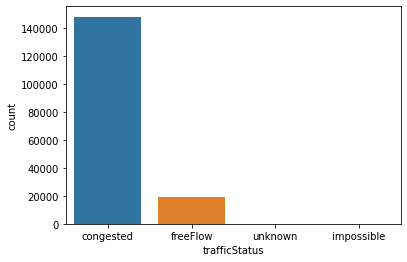

In [14]:
import seaborn as sns
sns.countplot(x="trafficStatus", data = train_df)

<AxesSubplot:xlabel='direction', ylabel='count'>

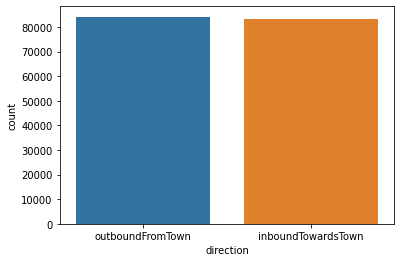

In [21]:
sns.countplot(x="direction", data = train_df)

<AxesSubplot:xlabel='road', ylabel='count'>

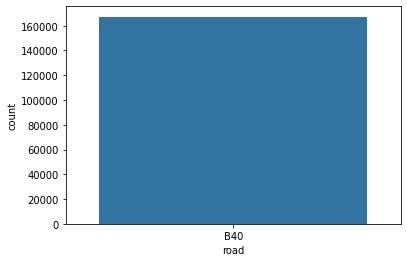

In [22]:
sns.countplot(x="road", data = train_df)

In [15]:
train_df['trafficStatus'].value_counts()

congested     148323
freeFlow       18904
unknown           60
impossible         4
Name: trafficStatus, dtype: int64

In [17]:
cols = list(train_df.columns.values)
cols

['id',
 'time',
 'latitude',
 'longitude',
 'direction',
 'road',
 'trafficStatus',
 'avgVehicleSpeed',
 'vehicleFlowRate',
 'trafficConcentration']

In [18]:
train_df = train_df[['id','time','latitude','longitude','direction','road','avgVehicleSpeed','vehicleFlowRate','trafficConcentration','trafficStatus']]

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167291 entries, 0 to 177539
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    167291 non-null  object 
 1   time                  167291 non-null  object 
 2   latitude              167291 non-null  float64
 3   longitude             167291 non-null  float64
 4   direction             167291 non-null  object 
 5   road                  167291 non-null  object 
 6   avgVehicleSpeed       167291 non-null  float64
 7   vehicleFlowRate       167291 non-null  int64  
 8   trafficConcentration  167291 non-null  float64
 9   trafficStatus         167291 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 18.1+ MB


In [23]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
train_df['direction']= label_encoder.fit_transform(train_df['direction'])
train_df['road']= label_encoder.fit_transform(train_df['road'])
train_df['trafficStatus']= label_encoder.fit_transform(train_df['trafficStatus'])

train_df['direction'].unique()
train_df['road'].unique()
train_df['trafficStatus'].unique()

array([0, 1, 3, 2])

In [24]:
print(train_df.shape)

(167291, 10)


Reshape X_train and X_test to 3D since Conv1D requires 3D data

In [25]:
X = train_df.iloc[:, 2:9]
y = train_df.iloc[:,9]

In [29]:
X

,latitude,longitude,direction,road,avgVehicleSpeed,vehicleFlowRate,trafficConcentration
0,49.493904,5.947297,1,0,58.0,114,0.0
1,49.493275,5.949434,1,0,61.0,108,1.0
2,49.491620,5.953512,1,0,69.0,133,0.0
3,49.493332,5.949474,0,0,58.0,1111,6.0
4,49.493960,5.947337,0,0,59.0,1116,5.0
...,...,...,...,...,...,...,...
177535,49.491695,5.953599,0,0,78.0,111,0.0
177536,49.497500,5.942809,1,0,92.0,45,0.0
177537,49.497510,5.942954,0,0,82.0,96,0.0
177538,49.493275,5.949434,1,0,93.0,40,0.0


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [27]:
X_train = X_train.values
X_test = X_test.values

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

In [28]:
print(X_train.shape)
print(X_test.shape)

(125468, 7, 1)
(41823, 7, 1)


Convert the Target label to categorical

In [30]:
target_train = y_train
target_test = y_test
Y_train=to_categorical(target_train)
Y_test=to_categorical(target_test)

In [31]:
print(Y_train.shape)
print(Y_test.shape)

(125468, 4)
(41823, 4)


Performance Evaluation Function

In [32]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)

Model Defination

In [33]:
verbose, epoch, batch_size = 1, 100, 32
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    #cnnmodel.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
    #cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(64, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(4, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 128)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                24640     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1

In [34]:
modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,verbose=verbose, validation_split=0.2, batch_size = batch_size)

Epoch 1/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.3316 - accuracy: 0.8983 - val_loss: 0.1526 - val_accuracy: 0.9210
Epoch 2/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1971 - accuracy: 0.9213 - val_loss: 0.1092 - val_accuracy: 0.9774
Epoch 3/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1192 - accuracy: 0.9513 - val_loss: 0.0665 - val_accuracy: 0.9797
Epoch 4/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0876 - accuracy: 0.9649 - val_loss: 0.0363 - val_accuracy: 0.9958
Epoch 5/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0840 - accuracy: 0.9664 - val_loss: 0.0465 - val_accuracy: 0.9806
Epoch 6/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.1025 - accuracy: 0.9623 - val_loss: 0.1184 - val_accuracy: 0.9484
Epoch 7/20
3137/3137 [==============================] - 5s 2ms/step - loss: 0.0947 - accuracy: 0.9669 - val_loss: 0.1876 - val_accuracy:

Plot the Training Accuracy and Loss

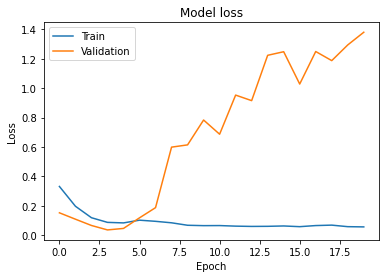

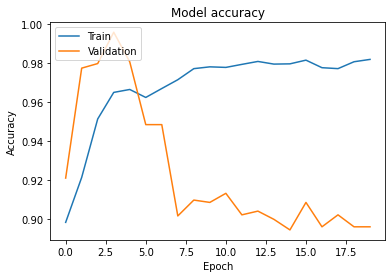

In [35]:
# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

Test the Model

In [36]:
cnnpredictions = cnnmodel.predict(X_test, verbose=1)

1307/1307 [==============================] - 1s 483us/step


Evaluate the Performance

In [37]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(Y_test,axis=1)
showResults(cnn_actual_value, cnn_predict)

Accuracy  : 0.8954403079645171
Precision : 0.906163246733776
f1Score : 0.8538617313110133
[[37067     0     0]
 [ 4360   383     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
cnn = accuracy_score(cnn_actual_value, cnn_predict)
f1cnn=f1_score(cnn_actual_value, cnn_predict, average='weighted') 

# KFold VAlidation

In [40]:
tempX=train_df.iloc[:,2:9].values
tempY=train_df.iloc[:,9].values
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X_train, target_train)
foldNum=0
for train_index, val_index in skf.split(X_train, target_train):
    foldNum+=1
    print("Results for fold",foldNum)
    X_traincv, X_valcv = tempX[train_index], tempX[val_index]
    Y_traincv, Y_valcv = tempY[train_index], tempY[val_index]

    X_traincv=X_traincv.reshape(X_traincv.shape[0],X_traincv.shape[1],1)
    X_valcv=X_valcv.reshape(X_valcv.shape[0],X_valcv.shape[1],1)
    # one hot encode
    Y_traincv = to_categorical(Y_traincv)
    Y_valcv = to_categorical(Y_valcv)
    
    history = cnnmodel.fit(X_traincv, Y_traincv, validation_data = (X_valcv, Y_valcv), epochs=20, batch_size=batch_size)  
    yPredict = cnnmodel.predict(X_valcv)

    #Converting one hot encoded test label to label    
    pred = np.argmax(yPredict, axis=1)
    val = np.argmax(Y_valcv, axis=1)
    
    showResults(val, pred)

Results for fold 1
Epoch 1/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0599 - accuracy: 0.9801 - val_loss: 1.2369 - val_accuracy: 0.9008
Epoch 2/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0581 - accuracy: 0.9817 - val_loss: 1.1064 - val_accuracy: 0.9066
Epoch 3/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0527 - accuracy: 0.9834 - val_loss: 1.0212 - val_accuracy: 0.9089
Epoch 4/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0499 - accuracy: 0.9839 - val_loss: 1.2110 - val_accuracy: 0.9089
Epoch 5/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0547 - accuracy: 0.9825 - val_loss: 1.1948 - val_accuracy: 0.9066
Epoch 6/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0544 - accuracy: 0.9828 - val_loss: 0.9662 - val_accuracy: 0.9126
Epoch 7/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0581 - accuracy: 0.9808 - val_loss: 1.1

C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2614/2614 [==============================] - 4s 2ms/step - loss: 0.0374 - accuracy: 0.9860 - val_loss: 0.8973 - val_accuracy: 0.9104
Epoch 2/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0357 - accuracy: 0.9861 - val_loss: 0.9325 - val_accuracy: 0.9104
Epoch 3/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0386 - accuracy: 0.9862 - val_loss: 0.9527 - val_accuracy: 0.9088
Epoch 4/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0356 - accuracy: 0.9867 - val_loss: 1.0903 - val_accuracy: 0.9081
Epoch 5/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0360 - accuracy: 0.9868 - val_loss: 0.9424 - val_accuracy: 0.9104
Epoch 6/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0370 - accuracy: 0.9869 - val_loss: 1.0504 - val_accuracy: 0.9081
Epoch 7/20
2614/2614 [==============================] - 4s 2ms/step - loss: 0.0352 - accuracy: 0.9874 - val_loss: 1.0677 - val_accuracy: 0.9081
Epo

C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test the Model

In [41]:
cnnpredictionscv = cnnmodel.predict(X_test, verbose=1)

1307/1307 [==============================] - 1s 463us/step


Evaluate the Performance

In [42]:
cnn_predictcv=np.argmax(cnnpredictionscv,axis=1)
cnn_actual_valuecv=np.argmax(Y_test,axis=1)
showResults(cnn_actual_valuecv, cnn_predictcv)

Accuracy  : 0.8996724290462186
Precision : 0.9098474701806231
f1Score : 0.8627765492068056
[[37063     0     4]
 [ 4188   555     0]
 [    4     0     9]]


In [43]:
cnnkv = accuracy_score(cnn_actual_valuecv, cnn_predictcv)
f1cnnkv=f1_score(cnn_actual_valuecv, cnn_predictcv, average='weighted') 

# **Hybrid CNN LSTM**

In [44]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 64)             384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 32)             6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 128)            82432     
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [45]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0528 - acc: 0.8869
Epoch 2/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0306 - acc: 0.9333
Epoch 3/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0196 - acc: 0.9729
Epoch 4/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0140 - acc: 0.9835
Epoch 5/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0113 - acc: 0.9875
Epoch 6/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0099 - acc: 0.9886
Epoch 7/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0087 - acc: 0.9903
Epoch 8/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0080 - acc: 0.9912
Epoch 9/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0074 - acc: 0.9918
Epoch 10/10
3921/3921 [==============================] - 17s 4ms/step - loss: 0.0068 - acc: 0.9929


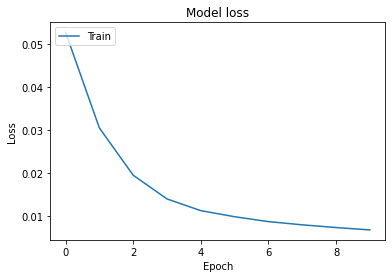

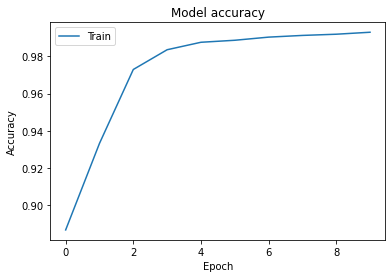

In [46]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [47]:
predictions = model.predict(X_test, verbose=1)

1307/1307 [==============================] - 2s 2ms/step


In [48]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 0.9996891662482367
Precision : 0.9993784414727076
f1Score : 0.9995337766211903
[[37067     0     0]
 [    0  4743     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
hyd = accuracy_score(actual_valuecv, predictcv)
f1hyd=f1_score(actual_valuecv, predictcv, average='weighted') 

# LSTM

In [50]:
from keras.callbacks import EarlyStopping
import math
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM

In [51]:
es=EarlyStopping(patience=7)
model=Sequential()
model.add(LSTM(13,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(units=4))
model.add(Activation('sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 13)                780       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 56        
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 836
Trainable params: 836
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.1427 - acc: 0.8867
Epoch 2/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0735 - acc: 0.8867
Epoch 3/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0608 - acc: 0.8867
Epoch 4/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0564 - acc: 0.8867
Epoch 5/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0544 - acc: 0.8867
Epoch 6/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0532 - acc: 0.8867
Epoch 7/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0525 - acc: 0.8867
Epoch 8/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0520 - acc: 0.8867
Epoch 9/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0517 - acc: 0.8867
Epoch 10/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0515 - acc: 0.8867


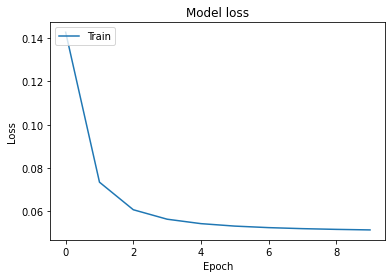

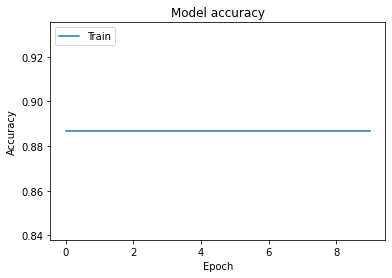

In [53]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [54]:
predictions = model.predict(X_test, verbose=1)

1307/1307 [==============================] - 1s 852us/step


In [55]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 0.886282667431796
Precision : 0.7854969665900194
f1Score : 0.8328518097019743
[[37067     0     0]
 [ 4743     0     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
lstm = accuracy_score(actual_valuecv, predictcv)
f1lstm=f1_score(actual_valuecv, predictcv, average='weighted') 

# BiLSTM

In [57]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [58]:
es=EarlyStopping(patience=7)
model=Sequential()
model.add(Bidirectional(LSTM(13,input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dense(units=4))
model.add(Activation('sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])


In [59]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0893 - acc: 0.8741
Epoch 2/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0598 - acc: 0.8867
Epoch 3/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0548 - acc: 0.8867: 0s - loss: 0.0548 - acc: 0.8
Epoch 4/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0533 - acc: 0.8867
Epoch 5/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.0525 - acc: 0.8867
Epoch 6/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0520 - acc: 0.8867
Epoch 7/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0517 - acc: 0.8867
Epoch 8/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0515 - acc: 0.8867
Epoch 9/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0513 - acc: 0.8867
Epoch 10/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.0512 - acc:

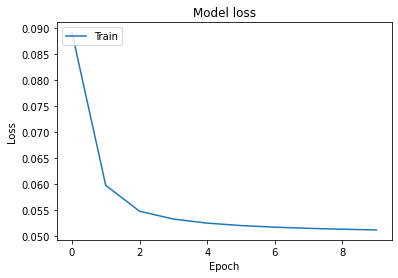

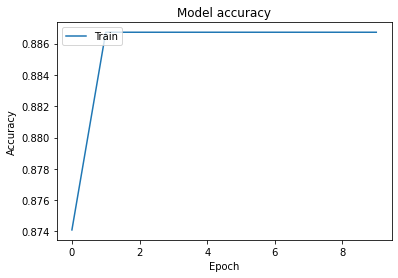

In [60]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [61]:
predictions = model.predict(X_test, verbose=1)

1307/1307 [==============================] - 1s 881us/step


In [62]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 0.886282667431796
Precision : 0.7854969665900194
f1Score : 0.8328518097019743
[[37067     0     0]
 [ 4743     0     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
bilstm = accuracy_score(actual_valuecv, predictcv)
f1bilstm=f1_score(actual_valuecv, predictcv, average='weighted') 

# RNN

In [64]:
from keras.layers import Dense, Dropout, Embedding, SimpleRNN

In [65]:
es=EarlyStopping(patience=7)
model=Sequential()
model.add(SimpleRNN(13,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(units=4))
model.add(Activation('sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])


In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 13)                195       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 56        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
3921/3921 [==============================] - 5s 1ms/step - loss: 0.0933 - acc: 0.8494
Epoch 2/10
3921/3921 [==============================] - 5s 1ms/step - loss: 0.0553 - acc: 0.8867
Epoch 3/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0525 - acc: 0.8867
Epoch 4/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0514 - acc: 0.8867
Epoch 5/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0509 - acc: 0.8867
Epoch 6/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0506 - acc: 0.8867
Epoch 7/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0504 - acc: 0.8867
Epoch 8/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0502 - acc: 0.8867
Epoch 9/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0501 - acc: 0.8867
Epoch 10/10
3921/3921 [==============================] - 4s 1ms/step - loss: 0.0500 - acc: 0.8867


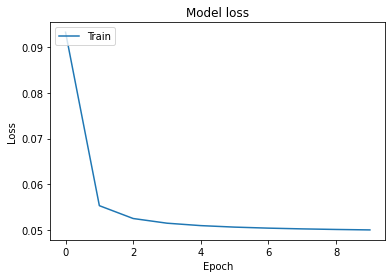

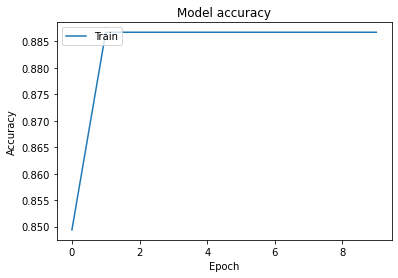

In [68]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [69]:
predictions = model.predict(X_test, verbose=1)

1307/1307 [==============================] - 1s 664us/step


In [70]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 0.886282667431796
Precision : 0.7854969665900194
f1Score : 0.8328518097019743
[[37067     0     0]
 [ 4743     0     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
rnn = accuracy_score(actual_valuecv, predictcv)
f1rnn=f1_score(actual_valuecv, predictcv, average='weighted') 

# GRU

In [72]:
from keras.layers import Dense, Dropout, Embedding, GRU
es=EarlyStopping(patience=7)
model=Sequential()
model.add(GRU(13,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(units=4))
model.add(Activation('sigmoid'))
model.compile(loss='squared_hinge',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 13)                624       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 56        
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
3921/3921 [==============================] - 11s 3ms/step - loss: 1.0464 - acc: 0.8431
Epoch 2/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8803 - acc: 0.8867
Epoch 3/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8659 - acc: 0.8867
Epoch 4/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8606 - acc: 0.8867
Epoch 5/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8578 - acc: 0.8867
Epoch 6/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8561 - acc: 0.8867
Epoch 7/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8549 - acc: 0.8867
Epoch 8/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8540 - acc: 0.8867
Epoch 9/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8533 - acc: 0.8867
Epoch 10/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.8528 - acc: 0.8867


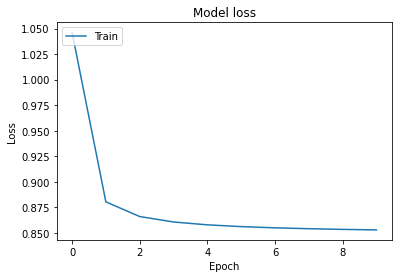

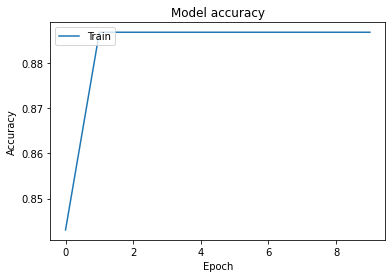

In [74]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [75]:
predictions = model.predict(X_test, verbose=1)
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

1307/1307 [==============================] - 1s 800us/step
Accuracy  : 0.886282667431796
Precision : 0.7854969665900194
f1Score : 0.8328518097019743
[[37067     0     0]
 [ 4743     0     0]
 [   13     0     0]]


C:\Users\Public\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
gru = accuracy_score(actual_valuecv, predictcv)
f1gru = f1_score(actual_valuecv, predictcv, average='weighted') 

# For Machine Learning

In [77]:
X = train_df.iloc[:, 2:9]
y = train_df.iloc[:,9]

In [78]:
X

,latitude,longitude,direction,road,avgVehicleSpeed,vehicleFlowRate,trafficConcentration
0,49.493904,5.947297,1,0,58.0,114,0.0
1,49.493275,5.949434,1,0,61.0,108,1.0
2,49.491620,5.953512,1,0,69.0,133,0.0
3,49.493332,5.949474,0,0,58.0,1111,6.0
4,49.493960,5.947337,0,0,59.0,1116,5.0
...,...,...,...,...,...,...,...
177535,49.491695,5.953599,0,0,78.0,111,0.0
177536,49.497500,5.942809,1,0,92.0,45,0.0
177537,49.497510,5.942954,0,0,82.0,96,0.0
177538,49.493275,5.949434,1,0,93.0,40,0.0


In [79]:
y

0         0
1         0
2         0
3         0
4         0
         ..
177535    0
177536    1
177537    1
177538    1
177539    0
Name: trafficStatus, Length: 167291, dtype: int32

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X, y)
predictions = RF.predict(X)
print("*Confusion Matrix for RF: ")
print(confusion_matrix(y, predictions))

*Confusion Matrix for RF: 
[[148323      0      0      0]
 [     0  18904      0      0]
 [     0      0      4      0]
 [     0      0      0     60]]


In [82]:
print("*Classification report for RF: ")
print(classification_report(y, predictions))

*Classification report for RF: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148323
           1       1.00      1.00      1.00     18904
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        60

    accuracy                           1.00    167291
   macro avg       1.00      1.00      1.00    167291
weighted avg       1.00      1.00      1.00    167291



In [83]:
val1 = accuracy_score(y, predictions) *100
print(val1)

100.0


In [84]:
f1rf = f1_score(y, predictions, average='weighted') 

# Decision Tree

In [85]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X, y)
predictions = DT.predict(X)
print("*Confusion Matrix for DT: ")
print(confusion_matrix(y, predictions))

*Confusion Matrix for DT: 
[[148323      0      0      0]
 [     0  18904      0      0]
 [     0      0      4      0]
 [     0      0      0     60]]


In [86]:
print("*Classification report for DT: ")
print(classification_report(y, predictions))

*Classification report for DT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148323
           1       1.00      1.00      1.00     18904
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        60

    accuracy                           1.00    167291
   macro avg       1.00      1.00      1.00    167291
weighted avg       1.00      1.00      1.00    167291



In [87]:
val2 = accuracy_score(y, predictions) *100
print(val2)

100.0


In [88]:
f1dt = f1_score(y, predictions, average='weighted') 

# Support Vector Machine

In [89]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, y)
predictions = clf.predict(X)
print("*Confusion Matrix for SVM: ")
print(confusion_matrix(y, predictions))

val4 = accuracy_score(y, predictions) *100
print(val4)

*Confusion Matrix for SVM: 
[[148320      3      0      0]
 [     8  18896      0      0]
 [     0      0      4      0]
 [     0      0      0     60]]
99.99342463133102


In [90]:
print("*Classification report for SVM: ")
print(classification_report(y, predictions))

*Classification report for SVM: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148323
           1       1.00      1.00      1.00     18904
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        60

    accuracy                           1.00    167291
   macro avg       1.00      1.00      1.00    167291
weighted avg       1.00      1.00      1.00    167291



In [91]:
f1svm = f1_score(y, predictions, average='weighted') 

# KNN

In [92]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, y)
predictions = clf.predict(X)
print("*Confusion Matrix for SVM: ")
print(confusion_matrix(y, predictions))

val3 = accuracy_score(y, predictions) *100
print(val3)

*Confusion Matrix for SVM: 
[[148287     33      0      3]
 [    56  18848      0      0]
 [     0      0      4      0]
 [     7      0      0     53]]
99.94082168197932


In [93]:
print("*Classification report for KNN: ")
print(classification_report(y, predictions))

*Classification report for KNN: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148323
           1       1.00      1.00      1.00     18904
           2       1.00      1.00      1.00         4
           3       0.95      0.88      0.91        60

    accuracy                           1.00    167291
   macro avg       0.99      0.97      0.98    167291
weighted avg       1.00      1.00      1.00    167291



In [94]:
f1knn = f1_score(y, predictions, average='weighted') 

# Voting Classifier

In [95]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = SVC(gamma='auto')
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = DecisionTreeClassifier()
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')
eclf1.fit(X, y)
predictions = eclf1.predict(X)
print("*Confusion Matrix for Voting Classifier: ")
print(confusion_matrix(y, predictions))

*Confusion Matrix for Voting Classifier: 
[[148323      0      0      0]
 [     0  18904      0      0]
 [     0      0      4      0]
 [     0      0      0     60]]


In [96]:
print("*Classification report for Voting Classifier: ")
print(classification_report(y, predictions))

*Classification report for Voting Classifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148323
           1       1.00      1.00      1.00     18904
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        60

    accuracy                           1.00    167291
   macro avg       1.00      1.00      1.00    167291
weighted avg       1.00      1.00      1.00    167291



In [97]:
val5 = accuracy_score(y, predictions) *100
print(val5)

100.0


In [98]:
f1vot = f1_score(y, predictions, average='weighted') 

# Comparison

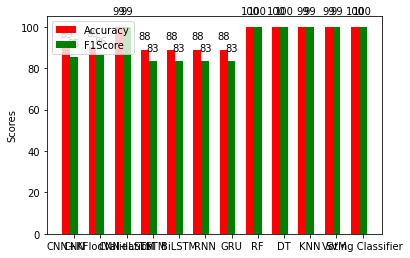

In [99]:
import numpy as np
import matplotlib.pyplot as plt

N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [cnn*100,cnnkv*100,hyd*100,lstm*100,bilstm*100,rnn*100,gru*100,val1,val2,val3,val4,val5]

rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [f1cnn*100,f1cnnkv*100,f1hyd*100,f1lstm*100,f1bilstm*100,f1rnn*100,f1gru*100,f1rf*100,f1dt*100,f1knn*100,f1svm*100,f1vot*100]
rects2 = ax.bar(ind+width, zvals, width, color='g')


ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('CNN','CNN+KFlodValidation','CNN+LSTM','LSTM','BiLSTM','RNN','GRU','RF','DT','KNN','SVM','Voting Classifier') )
ax.legend( (rects1[0], rects2[0]), ('Accuracy', 'F1Score') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [100]:
score = [cnn*100,cnnkv*100,hyd*100,lstm*100,bilstm*100,rnn*100,gru*100,val1,val2,val3,val4,val5]

In [101]:
#make variabel for save the result and to show it
classifier = ('CNN','CNN+KFlodValidation','CNN+LSTM','LSTM','BiLSTM','RNN','GRU','RF','DT','KNN','SVM','Voting Classifier')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[89.54403079645171, 89.96724290462186, 99.96891662482366, 88.6282667431796, 88.6282667431796, 88.6282667431796, 88.6282667431796, 100.0, 100.0, 99.94082168197932, 99.99342463133102, 100.0]


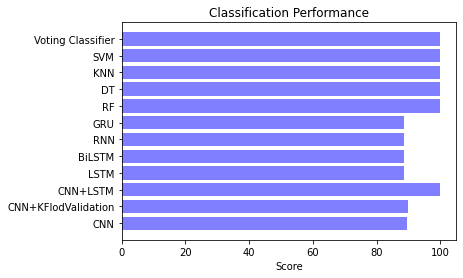

In [102]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()

In [103]:
import joblib
filename = 'model.sav'
joblib.dump(eclf1, filename)

['model.sav']